In [ ]:

from google.colab import drive, output
drive.mount('/content/drive')
import sys
%cd '/content/drive/MyDrive/Codigos/VQ-VAE'
sys.path.append('/content/drive/MyDrive/Codigos/VQ-VAE/data')
sys.path.append('/content/drive/MyDrive/Codigos/VQ-VAE/models')
#%load_ext autoreload
#%autoreload 2
output.clear()

In [ ]:
!pip install torchaudio
!pip install wandb --upgrade
!wandb login

output.clear()

In [ ]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


from six.moves import xrange

#import umap

import torch
import pandas as pd
import wandb

import torch.nn as nn
from scipy import signal
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from ResidualStack import ResidualStack

from Model import Model
from EcoData import EcoData


from Encoder import Encoder

from Decoder import Decoder

from Residual import Residual

from VectorQuantizer import VectorQuantizer
from VectorQuantizerEMA import VectorQuantizerEMA


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Train

We use the hyperparameters from the author's code:

In [ ]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [1]:
root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos'
labels_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Acceso_Datos_Humboldt/ensayo.xlsx'
names_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Acceso_Datos_Humboldt/RecordingsGuajiraTesisWeights.xlsx'

dataset = EcoData(root_path, labels_path, names_path, 60, "wav")
dataset_train, dataset_test = random_split(dataset,
                                           [round(len(dataset)*0.70), len(dataset) - round(len(dataset)*0.70)], 
                                           generator=torch.Generator().manual_seed(1024))

config = {
    "batch_size" : 1,
    "epochs": 1,
    "num_training_updates" : len(dataset_train),
    "num_hiddens" : 32,
    "num_residual_hiddens" : 32,
    "num_residual_layers" : 2,
    "embedding_dim" : 64,
    "num_embeddings" : 512,
    "commitment_cost" : 0.25,
    "decay" : 0.99,
    "learning_rate" : 1e-4,
    "dataset": "Audios Humboldt",
    "architecture": "VQ-VAE",
}

wandb.finish()
wandb.init(project="vq-vae", config=config)

training_loader = DataLoader(dataset_train, batch_size=config["batch_size"])
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])

NameError: ignored

In [ ]:
model = Model(config["num_hiddens"], config["num_residual_layers"], config["num_residual_hiddens"],
              config["num_embeddings"], config["embedding_dim"], 
              config["commitment_cost"], config["decay"]).to(device)

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=False)

In [ ]:
def testModel(model, iterator):
    model.eval()
    (valid_originals, _,_,_) = next( iterator)
    valid_originals = torch.reshape(valid_originals, (valid_originals.shape[0] * valid_originals.shape[1], 
                                                  valid_originals.shape[2], valid_originals.shape[3]))
    valid_originals = torch.unsqueeze(valid_originals,1)

    valid_originals = valid_originals.to(device)

    vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
    _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
    valid_reconstructions = model._decoder(valid_quantize)

    output =  torch.cat((valid_originals, valid_reconstructions), 0)
    img_grid = make_grid(output,nrow= 5,pad_value=20)

    recon_error = F.mse_loss(valid_originals, valid_reconstructions)

    fig, ax = plt.subplots(figsize=(20,5))
    ax.imshow(img_grid[1,:,:].cpu(), vmin=0,vmax=1)
    ax.axis("off")
    return fig, recon_error



Streaming output truncated to the last 5000 lines.
epoch: 0 of 1 	 iteration: 5501 of 15475 	 recon_error: 0.5426 	 recon_error: 0.5426 	 vq_loss: 0.0086
epoch: 0 of 1 	 iteration: 5502 of 15475 	 recon_error: 0.5446 	 recon_error: 0.5446 	 vq_loss: 0.0088
epoch: 0 of 1 	 iteration: 5503 of 15475 	 recon_error: 0.5429 	 recon_error: 0.5429 	 vq_loss: 0.0087
epoch: 0 of 1 	 iteration: 5504 of 15475 	 recon_error: 0.5437 	 recon_error: 0.5437 	 vq_loss: 0.0089
epoch: 0 of 1 	 iteration: 5505 of 15475 	 recon_error: 0.5426 	 recon_error: 0.5426 	 vq_loss: 0.0087
epoch: 0 of 1 	 iteration: 5506 of 15475 	 recon_error: 0.5419 	 recon_error: 0.5419 	 vq_loss: 0.0087
epoch: 0 of 1 	 iteration: 5507 of 15475 	 recon_error: 0.5419 	 recon_error: 0.5419 	 vq_loss: 0.0087
epoch: 0 of 1 	 iteration: 5508 of 15475 	 recon_error: 0.543 	 recon_error: 0.543 	 vq_loss: 0.0085
epoch: 0 of 1 	 iteration: 5509 of 15475 	 recon_error: 0.5449 	 recon_error: 0.5449 	 vq_loss: 0.0085
epoch: 0 of 1 	 iteratio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


epoch: 0 of 1 	 iteration: 10501 of 15475 	 recon_error: 0.4379 	 recon_error: 0.4379 	 vq_loss: 0.0124
epoch: 0 of 1 	 iteration: 10502 of 15475 	 recon_error: 0.4388 	 recon_error: 0.4388 	 vq_loss: 0.0122
epoch: 0 of 1 	 iteration: 10503 of 15475 	 recon_error: 0.4369 	 recon_error: 0.4369 	 vq_loss: 0.0125
epoch: 0 of 1 	 iteration: 10504 of 15475 	 recon_error: 0.4369 	 recon_error: 0.4369 	 vq_loss: 0.0124
epoch: 0 of 1 	 iteration: 10505 of 15475 	 recon_error: 0.4377 	 recon_error: 0.4377 	 vq_loss: 0.0121
epoch: 0 of 1 	 iteration: 10506 of 15475 	 recon_error: 0.4358 	 recon_error: 0.4358 	 vq_loss: 0.0121
epoch: 0 of 1 	 iteration: 10507 of 15475 	 recon_error: 0.4371 	 recon_error: 0.4371 	 vq_loss: 0.0119
epoch: 0 of 1 	 iteration: 10508 of 15475 	 recon_error: 0.4378 	 recon_error: 0.4378 	 vq_loss: 0.0118
epoch: 0 of 1 	 iteration: 10509 of 15475 	 recon_error: 0.4404 	 recon_error: 0.4404 	 vq_loss: 0.0113
epoch: 0 of 1 	 iteration: 10510 of 15475 	 recon_error: 0.4422 

loss,0.37455
perplexity,1.27417
recon_error,0.37455
vq_loss,0.01166
_runtime,27182
_timestamp,1628494336
_step,15504


loss,█▇▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
perplexity,▁████▇▇▇▇▇▇▇▇▇▇▇▆▇▆▆▇▆▇▆▆▆▇▆▆▆▆▆▆▆▆▆▆▆▇▆
recon_error,█▇▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
vq_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


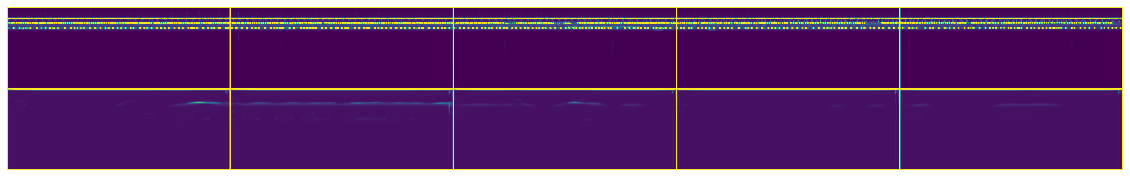

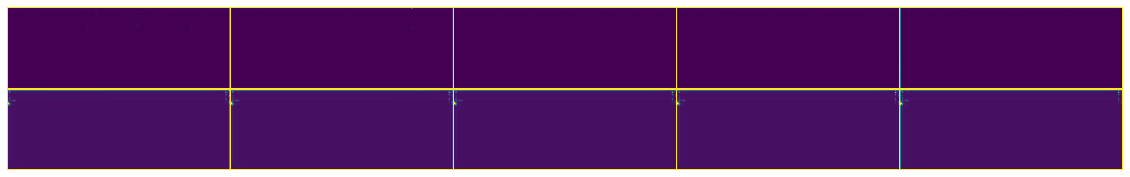

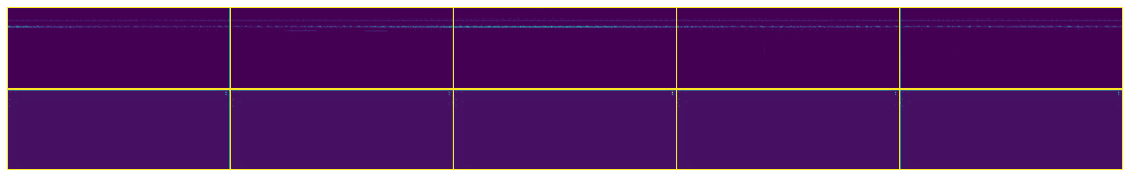

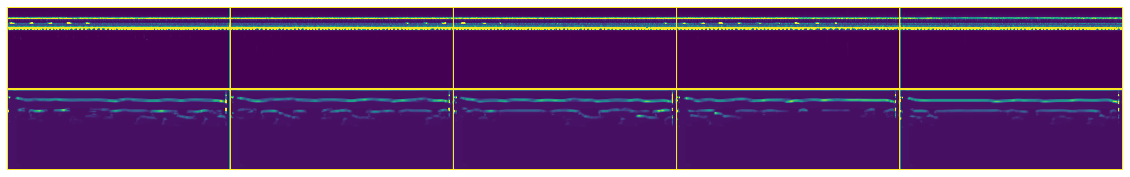

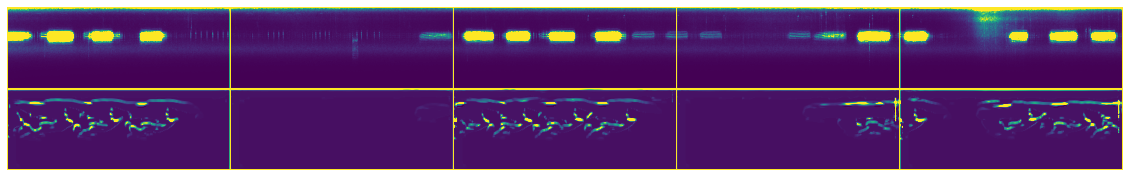

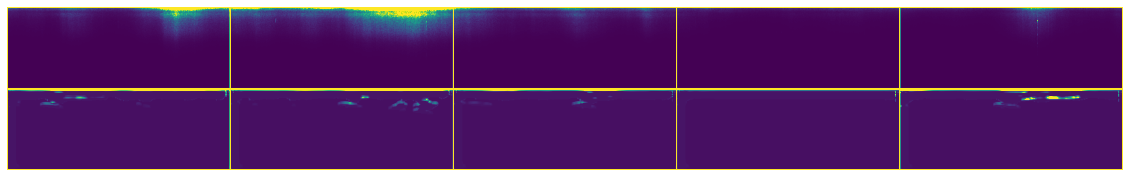

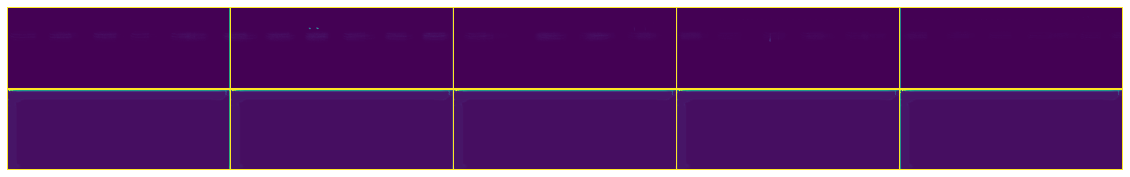

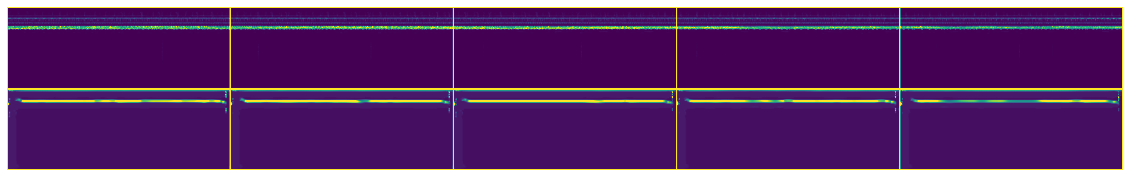

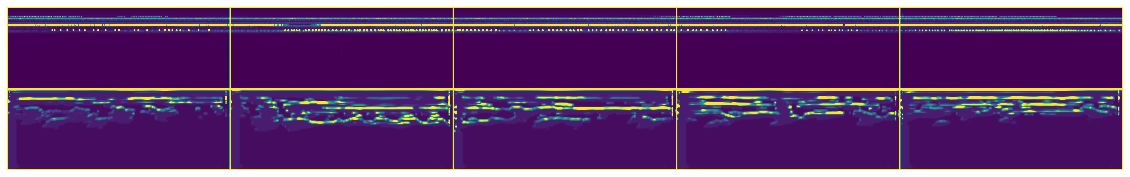

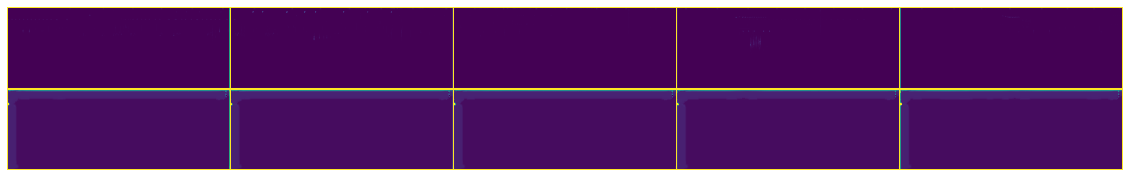

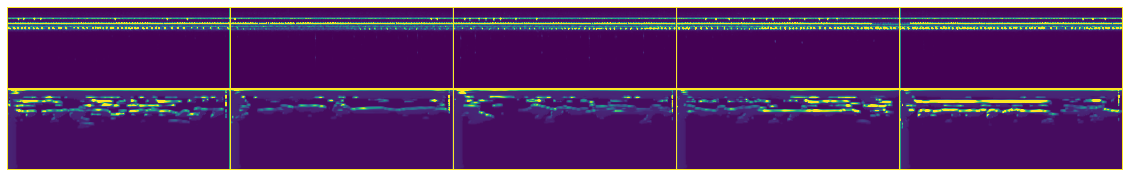

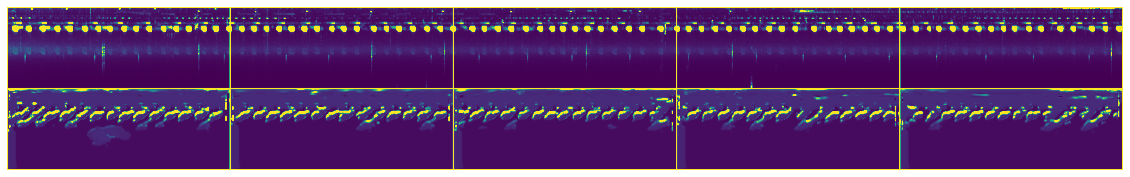

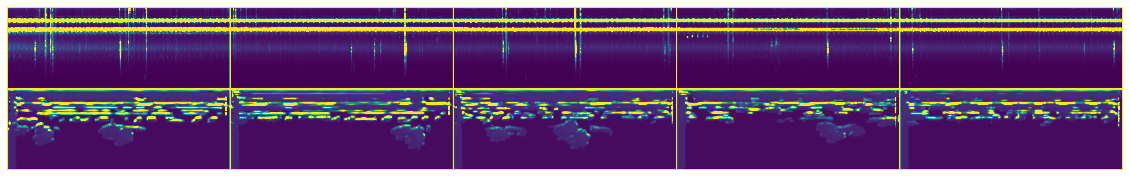

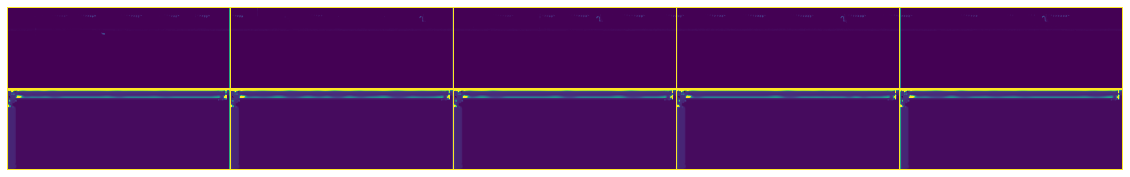

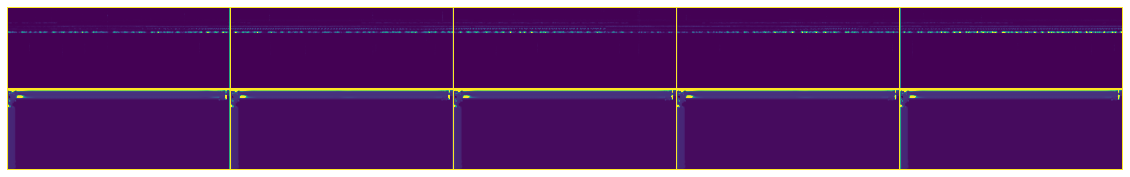

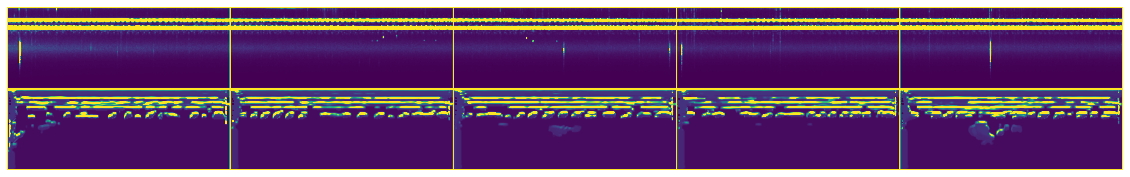

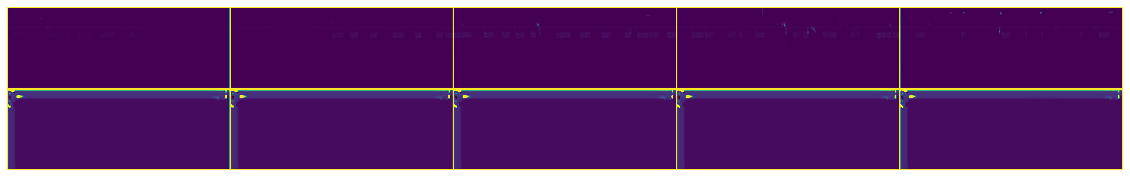

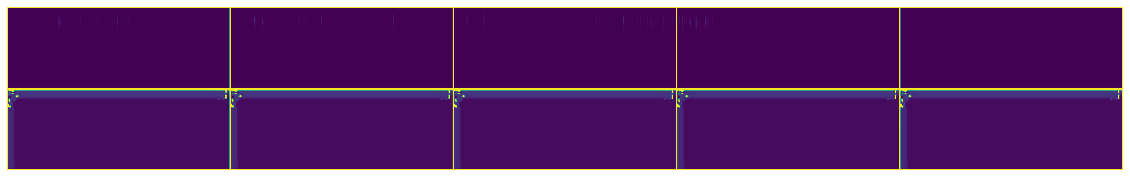

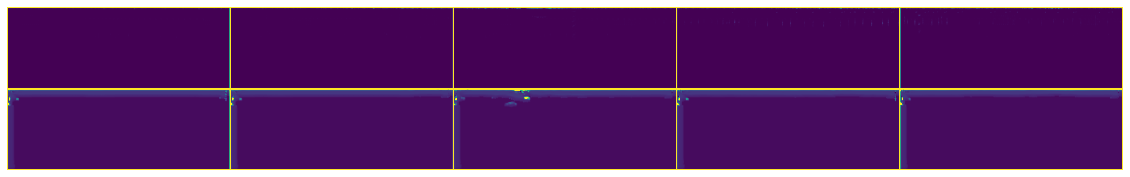

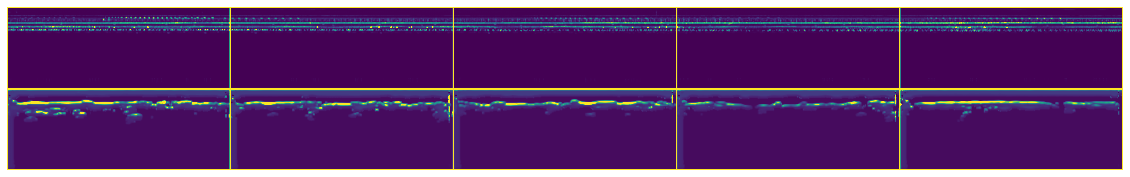

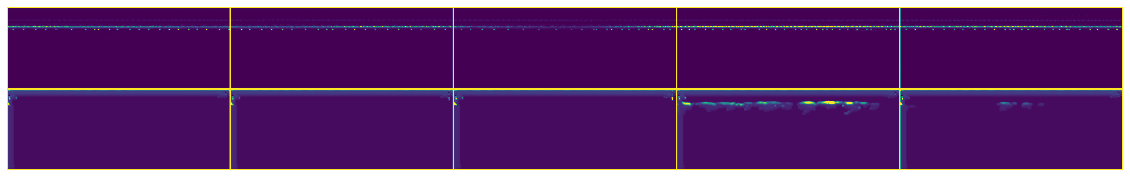

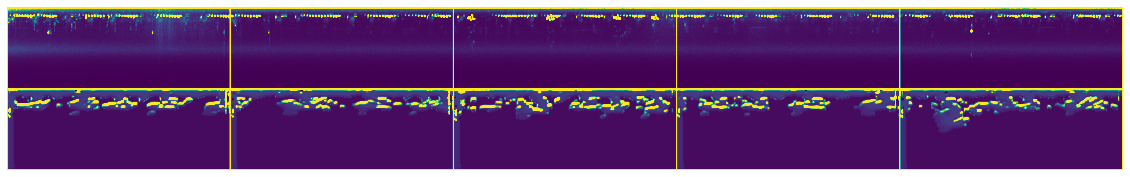

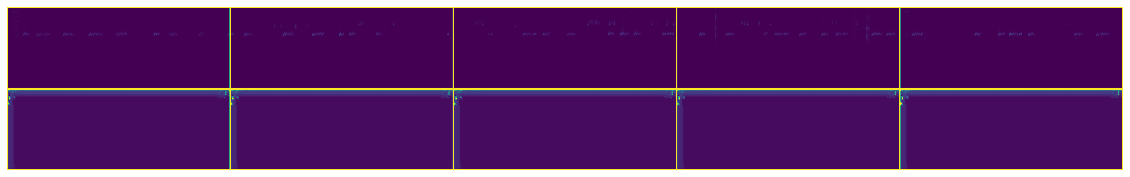

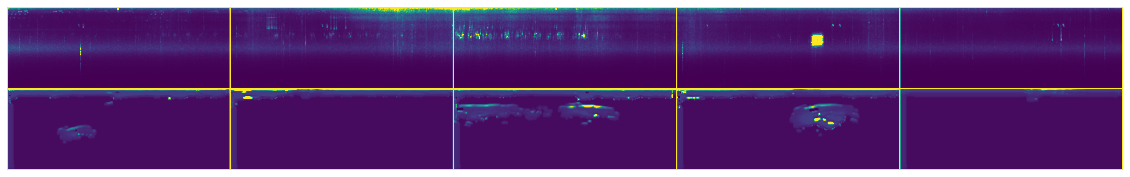

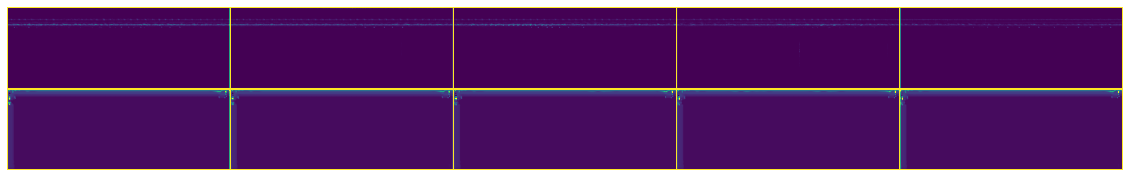

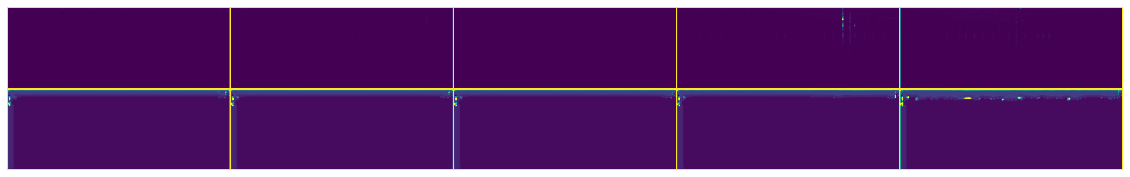

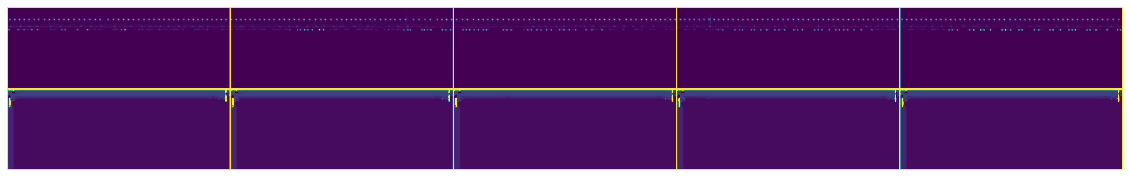

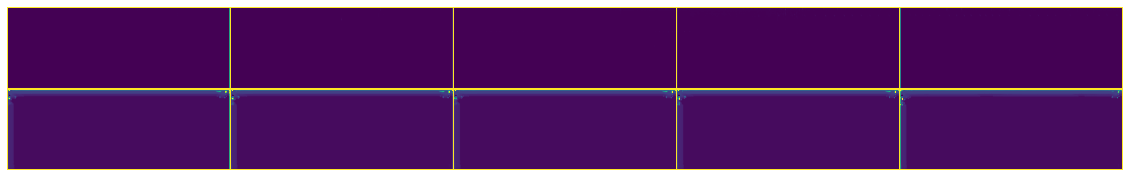

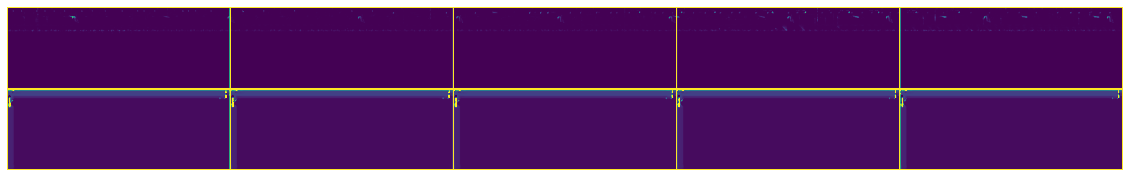

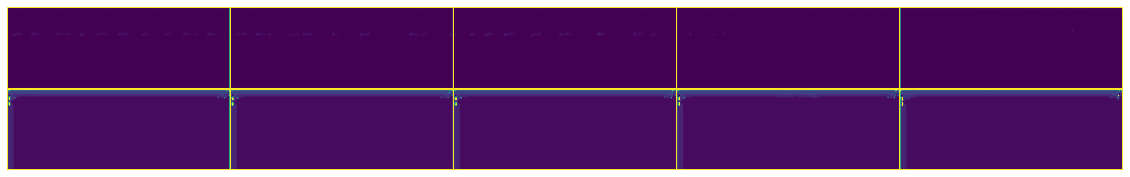

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []
wandb.watch(model, F.mse_loss, log="all", log_freq=1)
iterator = iter(test_loader)

for epoch in range(config["epochs"]):
  for i in xrange(config["num_training_updates"]):
      (data, _,_,_) = next(iter(training_loader))
      data = torch.reshape(data, (data.shape[0] * data.shape[1], data.shape[2], data.shape[3]))
      data = torch.unsqueeze(data,1)
      data = data.to(device)

      optimizer.zero_grad()
      vq_loss, data_recon, perplexity = model(data)
      
      recon_error = F.mse_loss(data_recon, data) #/ data_variance
      loss = recon_error + vq_loss
      loss.backward()

      optimizer.step()
      
      wandb.log({"loss":recon_error.item(),
                 "perplexity":perplexity.item(),
                 "recon_error": recon_error,
                 "vq_loss": vq_loss})
      print(f'epoch: {epoch} of {config["epochs"]} \t iteration: {(i+1)} of {config["num_training_updates"]} \t recon_error: {np.round(recon_error.item(),4)} \t recon_error: {np.round(recon_error.item(),4)} \t vq_loss: {np.round(vq_loss.item(),4)}')
      
      if (i+1) % 500 == 0:
        torch.save(model.state_dict(),f'model_{epoch}_{i}.pkl')
        fig, test_error = testModel(model, iterator)
        images = wandb.Image(fig, caption= f"recon_error: {np.round(test_error.item(),4)}")
        wandb.log({"examples": images})
                  
wandb.finish()

## View Embedding

In [ ]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

NameError: ignored

In [ ]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

In [ ]:
model

NameError: ignored